In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def analytic_sol(mu, x, y, t):
    return np.sin(x) * np.sin(y) * np.sin(mu * t)

def f(a, b, mu, x, y, t):
    return np.sin(x) * np.sin(y) * (mu * np.cos(mu * t) + (a + b) * np.sin(mu * t))

def phi1(mu, y, t):
    return 0

def phi2(mu, y, t):
    return -np.sin(y) * np.sin(mu * t)

def phi3(mu, x, t):
    return 0

def phi4(mu, x, t):
    return -np.sin(x) * np.sin(mu * t)

def norm(U1, U2):
    max = 0
    for i in range(U1.shape[0]):
        for j in range(U1.shape[1]):
            if abs(U1[i, j] - U2[i, j]) > max:
                max = abs(U1[i, j] - U2[i, j])

    return max

def tdma(a, b, c, d, s):
    P = np.zeros(s + 1)
    Q = np.zeros(s + 1)

    P[0] = -c[0] / b[0]
    Q[0] = d[0] / b[0]

    k = s - 1
    for i in range(1, s):
        P[i] = -c[i] / (b[i] + a[i] * P[i - 1])
        Q[i] = (d[i] - a[i] * Q[i - 1]) / (b[i] + a[i] * P[i - 1])
    P[k] = 0
    Q[k] = (d[k] - a[k] * Q[k - 1]) / (b[k] + a[k] * P[k - 1])

    x = np.zeros(s)
    x[k] = Q[k]

    for i in range(s - 2, -1, -1):
        x[i] = P[i] * x[i + 1] + Q[i]

    return x

In [3]:
def variable_directions(a1, b1, mu, x, y, hx, hy, K, tau, t):
    U = np.zeros((K, len(x), len(y)))
    sigma_a = (a1 * tau) / (2 * hx ** 2)
    sigma_b = (b1 * tau) / (2 * hy ** 2)

    for k in range(K):
        for i in range(len(x)):
            U[k, i, 0] = phi3(mu, x[i], t)
            U[k, i, -1] = phi4(mu, x[i], t) * hy + U[k, i, -2]
    for k in range(K):
        for j in range(len(y)):
            U[k, 0, j] = phi1(mu, y[j], t)
            U[k, -1, j] = phi2(mu, y[j], t) * hx + U[k, -2, j]

    for k in range(1, K):
        U_temp = np.zeros((len(x), len(y)))
        a = np.zeros(len(y))
        b = np.zeros(len(y))
        c = np.zeros(len(y))
        d = np.zeros(len(y))
        t += tau / 2
        for i in range(1, len(x) - 1):
            for j in range(1, len(y) - 1):
                a[j] = -sigma_a
                b[j] = 1 + 2 * sigma_a
                c[j] = -sigma_a
                d[j] = (f(a1, b1, mu, x[i], y[j], t) * tau) / 2 + sigma_b * (
                            U[k - 1, i, j + 1] - 2 * U[k - 1, i, j] + U[k - 1, i, j - 1]) \
                       + U[k - 1, i, j]
            b[0] = 1
            c[0] = 0
            d[0] = phi3(mu, x[i], t)
            a[-1] = -1
            b[-1] = 1
            d[-1] = phi4(mu, x[i], t) * hy
            u_new = tdma(a, b, c, d, len(d))
            U_temp[i] = u_new
            for j in range(len(y)):
                U_temp[0, j] = phi1(mu, y[j], t)
                U_temp[-1, j] = phi2(mu, y[j], t) * hx + U_temp[-2, j]

        a = np.zeros(len(x))
        b = np.zeros(len(x))
        c = np.zeros(len(x))
        d = np.zeros(len(x))
        t += tau / 2
        for j in range(1, len(y) - 1):
            for i in range(1, len(x) - 1):
                a[i] = -sigma_b
                b[i] = 1 + 2 * sigma_b
                c[i] = -sigma_b
                d[i] = (f(a1, b1, mu, x[i], y[j], t) * tau) / 2 + sigma_a * (
                            U_temp[i + 1, j] - 2 * U_temp[i, j] + U_temp[i - 1, j]) \
                       + U_temp[i, j]
            b[0] = 1
            c[0] = 0
            d[0] = phi1(mu, y[j], t)
            a[-1] = -1
            b[-1] = 1
            d[-1] = phi2(mu, y[j], t) * hx
            u_new = tdma(a, b, c, d, len(d))
            for i in range(len(u_new)):
                U[k, i, j] = u_new[i]
            for i in range(len(x)):
                U[k, i, 0] = phi3(mu, x[i], t)
                U[k, i, -1] = phi4(mu, x[i], t) * hy + U[k, i, -2]

    return U.transpose()

In [4]:
Nx = 20
Ny = 20
K = 1000
time = 3

hx = (np.pi - 0) / Nx
hy = (np.pi - 0) / Ny
x = np.arange(0, np.pi + hx / 2 - 1e-4, hx)
y = np.arange(0, np.pi + hy / 2 - 1e-4, hy)
tau = time / K
T = np.arange(0, time, tau)
t = 0

a, b, mu = 1, 1, 1
# a, b, mu = 2, 1, 1
# a, b, mu = 1, 2, 1
# a, b, mu = 1, 1, 2

U = variable_directions(a, b, mu, x, y, hx, hy, K, tau, t)


dt = 3
X, Y = np.meshgrid(x, y)
U_analytic = analytic_sol(mu, X, Y, T[dt])

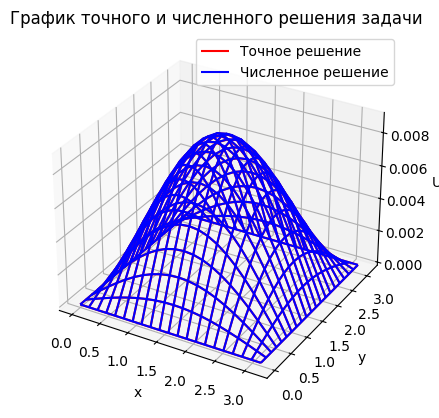

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title("График точного и численного решения задачи")
ax.plot_wireframe(X, Y, U_analytic, color="red", label="Точное решение")
ax.plot_wireframe(X, Y, U[:, :, dt], color="blue", label="Численное решение")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("U")
ax.legend()
plt.show()

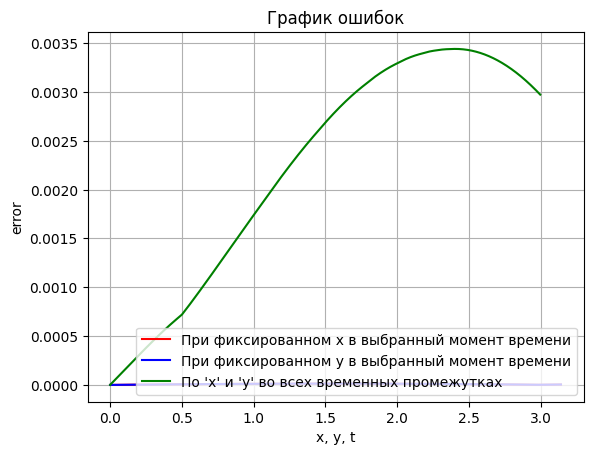

In [6]:
fig = plt.figure()
error_x = []
error_y = []
error_t = []
for i in range(len(x)):
    error_y.append(max(abs(U_analytic[:, i] - U[:, i, dt])))
for j in range(len(y)):
    error_x.append(max(abs(U_analytic[j, :] - U[j, :, dt])))
for k in range(K):
    error_t.append(norm(analytic_sol(mu, X, Y, T[k]), U[:, :, k]))
plt.title("График ошибок")
plt.plot(x, error_y, label="При фиксированном x в выбранный момент времени", color="red")
plt.plot(y, error_x, label="При фиксированном y в выбранный момент времени", color="blue")
plt.plot(T, error_t, label="По 'x' и 'y' во всех временных промежутках", color="green")
plt.xlabel("x, y, t")
plt.ylabel("error")
plt.grid()
plt.legend()

In [7]:
def fractional_step(a1, b1, mu, x, y, hx, hy, K, tau, t):
    U = np.zeros((K, len(x), len(y)))
    sigma_a = (a1 * tau) / hx ** 2
    sigma_b = (b1 * tau) / hy ** 2

    for k in range(K):
        for i in range(len(x)):
            U[k, i, 0] = phi3(mu, x[i], t)
            U[k, i, -1] = phi4(mu, x[i], t) * hy + U[k, i, -2]
    for k in range(K):
        for j in range(len(y)):
            U[k, 0, j] = phi1(mu, y[j], t)
            U[k, -1, j] = phi2(mu, y[j], t) * hx + U[k, -2, j]

    for k in range(1, K):
        U_temp = np.zeros((len(x), len(y)))
        a = np.zeros(len(y))
        b = np.zeros(len(y))
        c = np.zeros(len(y))
        d = np.zeros(len(y))
        t += tau / 2
        for i in range(1, len(x) - 1):
            for j in range(1, len(y) - 1):
                a[j] = -sigma_a
                b[j] = 1 + 2 * sigma_a
                c[j] = -sigma_a
                d[j] = (f(a1, b1, mu, x[i], y[j], t) * tau) / 2 + U[k - 1, i, j]
            b[0] = 1
            c[0] = 0
            d[0] = phi3(mu, x[i], t)
            a[-1] = -1
            b[-1] = 1
            d[-1] = phi4(mu, x[i], t) * hy
            u_new = tdma(a, b, c, d, len(d))
            U_temp[i] = u_new
            for j in range(len(y)):
                U_temp[0, j] = phi1(mu, y[j], t)
                U_temp[-1, j] = phi2(mu, y[j], t) * hx + U_temp[-2, j]

        a = np.zeros(len(x))
        b = np.zeros(len(x))
        c = np.zeros(len(x))
        d = np.zeros(len(x))
        t += tau / 2
        for j in range(1, len(y) - 1):
            for i in range(1, len(x) - 1):
                a[i] = -sigma_b
                b[i] = 1 + 2 * sigma_b
                c[i] = -sigma_b
                d[i] = (f(a1, b1, mu, x[i], y[j], t) * tau) / 2 + U_temp[i, j]
            b[0] = 1
            c[0] = 0
            d[0] = phi1(mu, y[j], t)
            a[-1] = -1
            b[-1] = 1
            d[-1] = phi2(mu, y[j], t) * hx
            u_new = tdma(a, b, c, d, len(d))
            for i in range(len(u_new)):
                U[k, i, j] = u_new[i]
            for i in range(len(x)):
                U[k, i, 0] = phi3(mu, x[i], t)
                U[k, i, -1] = phi4(mu, x[i], t) * hy + U[k, i, -2]

    return U.transpose()

In [8]:
Nx = 20
Ny = 20
K = 1000
time = 3

hx = (np.pi - 0) / Nx
hy = (np.pi - 0) / Ny
x = np.arange(0, np.pi + hx / 2 - 1e-4, hx)
y = np.arange(0, np.pi + hy / 2 - 1e-4, hy)
tau = time / K
T = np.arange(0, time, tau)
t = 0

a, b, mu = 1, 1, 1
a, b, mu = 2, 1, 1
# a, b, mu = 1, 2, 1
# a, b, mu = 1, 1, 2

U = fractional_step(a, b, mu, x, y, hx, hy, K, tau, t)


dt = 3
X, Y = np.meshgrid(x, y)
U_analytic = analytic_sol(mu, X, Y, T[dt])

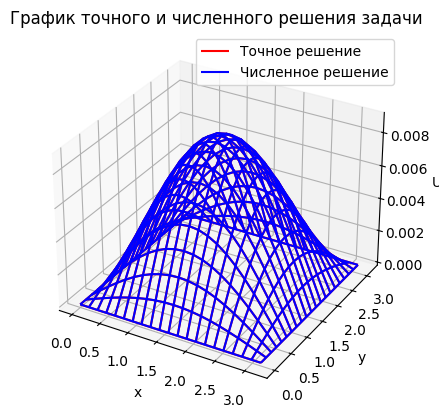

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_title("График точного и численного решения задачи")
ax.plot_wireframe(X, Y, U_analytic, color="red", label="Точное решение")
ax.plot_wireframe(X, Y, U[:, :, dt], color="blue", label="Численное решение")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("U")
ax.legend()
plt.show()

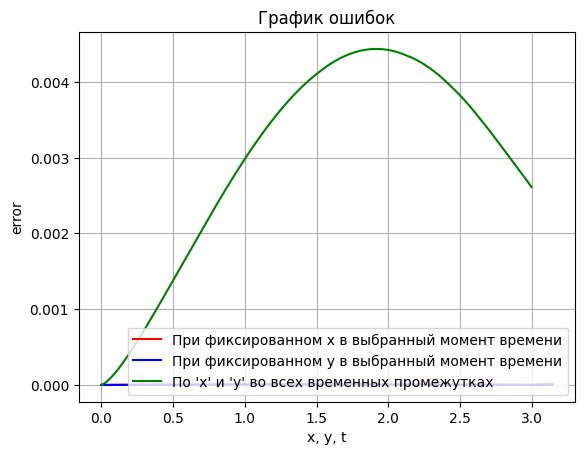

In [10]:
fig = plt.figure()
error_x = []
error_y = []
error_t = []
for i in range(len(x)):
    error_y.append(max(abs(U_analytic[:, i] - U[:, i, dt])))
for j in range(len(y)):
    error_x.append(max(abs(U_analytic[j, :] - U[j, :, dt])))
for k in range(K):
    error_t.append(norm(analytic_sol(mu, X, Y, T[k]), U[:, :, k]))
plt.title("График ошибок")
plt.plot(x, error_y, label="При фиксированном x в выбранный момент времени", color="red")
plt.plot(y, error_x, label="При фиксированном y в выбранный момент времени", color="blue")
plt.plot(T, error_t, label="По 'x' и 'y' во всех временных промежутках", color="green")
plt.xlabel("x, y, t")
plt.ylabel("error")
plt.grid()
plt.legend()